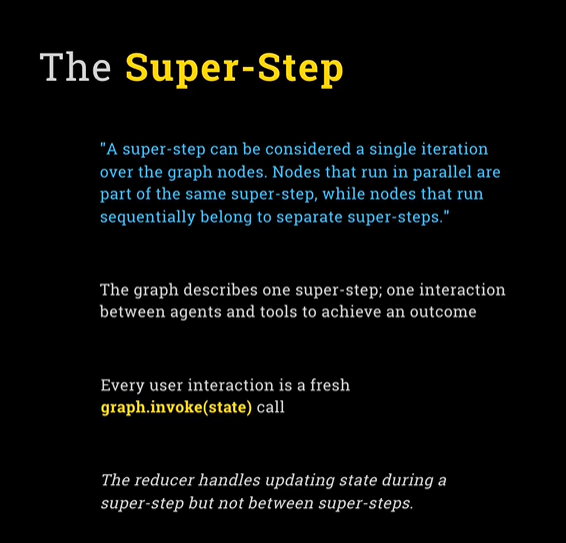

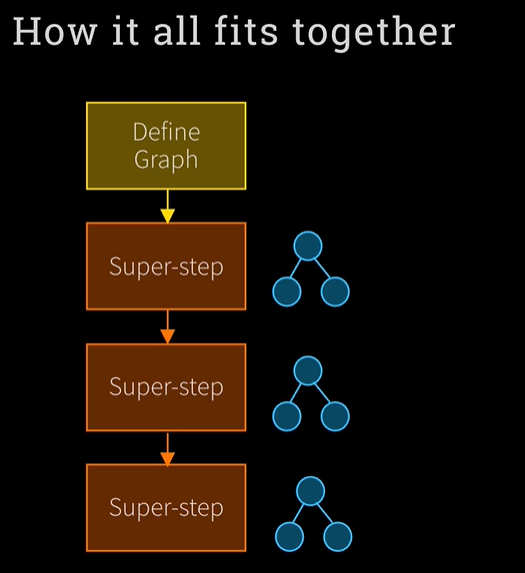

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

e:\ML Projects\Autogen-AgentAI\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)

True

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. France is a semi-presidential republic. Its capital, largest city and main cultural and economic centre is Paris. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... 7 likes, 0 comments - iflytours_ on January 2, 2025: "Paris, the capital of France, is often referred to as the 

In [4]:
from langchain.agents import Tool

tool_search = Tool(
    name = "search",
    func=serper.run,
    description="Useful when you need some more information from online search"
)

In [5]:
tool_search.invoke("What is the Capital of France")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris became capital of France because France evolved from a federation of counties to a kingdom, where the king was living a Paris. The ... 7 likes, 0 comment

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    "Send a push notification to the user"
    requests.post(pushover_url, data = {"token" : pushover_token, "user" : pushover_user, "message" : text})

In [7]:
tool_push = Tool(
    name = "send_push_notification",
    func = push,
    description = "Useful when you want to send a push notification"
)

tool_push.invoke("Hello me")

Bring them together

In [8]:
tools = [tool_search, tool_push]

In [9]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [10]:
graph_builder = StateGraph(State)

In [11]:
llm = ChatOpenAI(model = "gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [12]:
def chatbot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [13]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [14]:
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

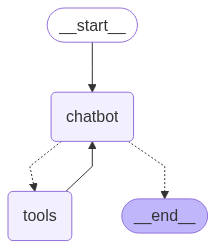

In [15]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
def chat(user_input: str, history):
    result = graph.invoke({"messages" : [{"role": "user", "content" : user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(chat, type = "messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [18]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

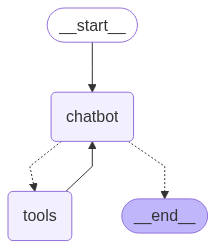

In [19]:
graph_builder = StateGraph(State)

llm = ChatOpenAI(model = "gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    print(state)
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
config = {"configurable" : {"thread_id" : "1"}}

def chat(user_input : str, history):
    result = graph.invoke({"messages" : [{"role" : "user", "content" : user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type = "messages").launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='What is the capital of france?', additional_kwargs={}, response_metadata={}, id='35ec51f2-5a25-413a-b21b-4028370bf180')]}
{'messages': [HumanMessage(content='What is the capital of france?', additional_kwargs={}, response_metadata={}, id='35ec51f2-5a25-413a-b21b-4028370bf180'), AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 93, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BvjebEP586KY8EQRUkOLZUkxrRqm4', 'finish_reason': 'stop', 'logprobs': None}, id='run-f59d635b-2332-4455-adc5-5fa093123003-0', usage_metadata={'input_tokens': 93, 'output_tokens': 8, 'total_tokens': 101, 'i

In [22]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='What is the capital of france?', additional_kwargs={}, response_metadata={}, id='35ec51f2-5a25-413a-b21b-4028370bf180'), AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 93, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BvjebEP586KY8EQRUkOLZUkxrRqm4', 'finish_reason': 'stop', 'logprobs': None}, id='run-f59d635b-2332-4455-adc5-5fa093123003-0', usage_metadata={'input_tokens': 93, 'output_tokens': 8, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='My nam